In [7]:
from optim_forward_without_iteration import OptimReluMaxLinear as OptimForward
from optim_relu_max_linear import OptimReluMaxLinear
import triton
import torch

In [8]:
B = 16
L = 100
D = 300
V = 10000

x = torch.randn(B, L, D, requires_grad=True, dtype=torch.float64, device='cuda')
w = torch.randn(D, V, requires_grad=True, dtype=torch.float64, device='cuda')
b = -torch.sqrt(-2 * torch.log(torch.tensor(0.005, device='cuda').repeat(V))) * 21

res = x @ w + b.reshape(1, 1, *b.shape).max(axis=1)[0]
print((res > 0).sum() / (B * V))

tensor(0.0047, device='cuda:0')


In [9]:
UPPER_LIMIT = 11  ## change ca pour diminuer la consommation de memoire.
B = 16
L = 100
D = 300
x_vals = [10000 * i for i in range(1, UPPER_LIMIT)]

In [10]:
configs = []

configs.append(
    triton.testing.Benchmark(
        x_names=["V"],  # Argument names to use as an x-axis for the plot
        x_vals=x_vals,  # Different possible values for `x_name`
        line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        # Don't compare to cublas for fp8 cases as torch.matmul doesn't support fp8 at the moment.
        line_vals= ["with_iteration", "without_iteration"],  # Label name for the lines
        line_names= ["with_iteration", "without_iteration"],  # Line styles
        styles=[("green", "-"), ("blue", "-")],
        ylabel="GB/s",  # Label name for the y-axis
        plot_name="relu_max_backward_performance",
        args={'B' : B, 'L' : L, 'D': D},
    ))

In [11]:
@triton.testing.perf_report(configs)
def benchmark(B, L, D, V, provider):
    x = torch.randn(B, L, D, requires_grad=True, dtype=torch.float64, device='cuda')
    w = torch.randn(D, V, requires_grad=True, dtype=torch.float64, device='cuda')
    b = -torch.sqrt(-2 * torch.log(torch.tensor(0.005, device='cuda').repeat(V))) * 21
    list_lengths = torch.randint(0, L, [B])
    mask = torch.ones(B, L).cuda()
    for i, l in enumerate(list_lengths):
        mask[i, l:] = 0
    
    quantiles = [0.5, 0.2, 0.8]
    
    print(f'---------- V : {V}\tprovider : {provider} ----------')
    if provider == 'without_iteration':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: OptimForward.apply(x, w, b, mask), quantiles=quantiles)
        
    if provider == 'with_iteration':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: OptimReluMaxLinear.apply(x, w, b, mask) , quantiles=quantiles)
    
    gbps = lambda ms: 8 * (B * L * D + D * V + V) / (ms * 1e-3) / (1024 ** 3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)
        

---------- V : 10000	provider : with_iteration ----------
---------- V : 10000	provider : without_iteration ----------
---------- V : 20000	provider : with_iteration ----------
---------- V : 20000	provider : without_iteration ----------
---------- V : 30000	provider : with_iteration ----------
---------- V : 30000	provider : without_iteration ----------
---------- V : 40000	provider : with_iteration ----------
---------- V : 40000	provider : without_iteration ----------
---------- V : 50000	provider : with_iteration ----------
---------- V : 50000	provider : without_iteration ----------
---------- V : 60000	provider : with_iteration ----------
---------- V : 60000	provider : without_iteration ----------
---------- V : 70000	provider : with_iteration ----------
---------- V : 70000	provider : without_iteration ----------
---------- V : 80000	provider : with_iteration ----------
---------- V : 80000	provider : without_iteration ----------
---------- V : 90000	provider : with_iteration -

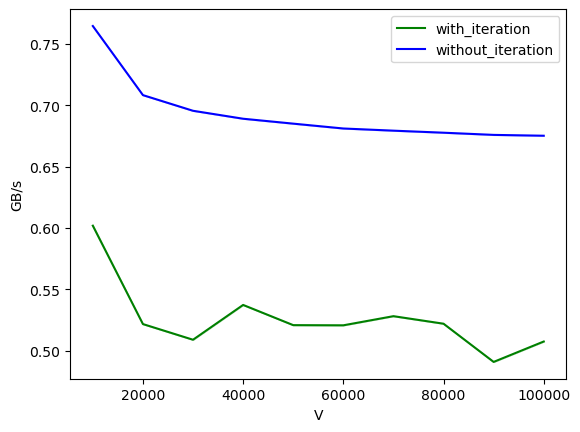

relu_max_backward_performance:
          V  with_iteration  without_iteration
0   10000.0        0.601824           0.764691
1   20000.0        0.521568           0.708329
2   30000.0        0.508790           0.695553
3   40000.0        0.537180           0.689069
4   50000.0        0.520700           0.685063
5   60000.0        0.520558           0.681105
6   70000.0        0.528012           0.679336
7   80000.0        0.521865           0.677672
8   90000.0        0.490698           0.675890
9  100000.0        0.507342           0.675202


In [12]:
benchmark.run(show_plots=True, print_data=True)